# Problem Statement

[An article in the Dallas Observer](https://www.dallasobserver.com/restaurants/dallas-restaurant-inspections-suffer-from-delays-poor-record-keeping-and-overworked-staff-10697588) unearthed a massive problem in the city's ability to follow up on restaurants requiring reinspection due to a low grade upon original inspection.  Dallas states that out of a scale from 1-100, any facility that scores between 70-79 requires reinspection within 30 days, between 60-69 requires reinspection within 10 days, and below 60 requires reinspection ASAP.

The article points out many flaws in the city's ability to reinspect restaurants within its own self-imposed timeframes,.  Until the department can hopefully become better-staffed, I am looking to build a classification model that can predict how a restaurant will perform upon reinspection.  This way, if the city is still struggling to reinspect restaurants in a timely manner, they can refer to the model in order to prioritize certain facilities to reinspect.



In [1154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist


%matplotlib inline

# Data Collection

In [1155]:
df = pd.read_csv('./data/Restaurant_and_Food_Establishment_Inspections__October_2016_to_Present_.csv')

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,97,103,105,106,107,109,110) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1156]:
df.head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
0,FRESHII,Routine,10/31/2018,96,2414,VICTORY PARK,NaN,LN,NaN,2414 VICTORY PARK LN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2018,FY2019,"2414 VICTORY PARK LN\n(32.787625, -96.809294)"
1,MICKLE CHICKEN,Routine,10/30/2019,100,3203,CAMP WISDOM,W,RD,NaN,3203 W CAMP WISDOM RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2019,FY2020,"3203 W CAMP WISDOM RD\n(32.662584, -96.873446)"
2,WORLD TRADE CENTER MARKET,Routine,11/03/2016,100,2050,STEMMONS,N,FRWY,NaN,2050 N STEMMONS FRWY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2016,FY2017,"2050 N STEMMONS FRWY\n(32.801934, -96.825878)"
3,DUNKIN DONUTS,Routine,10/30/2019,99,8008,HERB KELLEHER,NaN,WAY,C2174,8008 HERB KELLEHER WAY STE# C2174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct 2019,FY2020,8008 HERB KELLEHER WAY STE# C2174
4,CANVAS HOTEL - 6TH FLOOR,Routine,06/11/2018,100,1325,LAMAR,S,ST,NaN,1325 S LAMAR ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"1325 S LAMAR ST\n(39.69335, -105.067425)"


# Data Cleaning

In [1157]:
df.shape # checks shape of data

(44656, 114)

In [1158]:
df.isnull().sum().sort_values(ascending = False).head() #check nulls

Violation Detail - 25         44654
Violation Memo - 25           44653
Violation Points - 25         44653
Violation Description - 25    44653
Violation Description - 24    44649
dtype: int64

There are a few restaurants with null values for restaurant name.  Let's investigate this.

In [1159]:
df.loc[df['Restaurant Name'].isnull()]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
20592,NaN,Routine,02/21/2018,86,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
21643,NaN,Routine,08/28/2017,87,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
24064,NaN,Routine,07/28/2017,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul 2017,FY2017,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
24612,NaN,Routine,08/06/2018,91,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
26713,NaN,Routine,02/02/2017,88,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
33050,NaN,Routine,11/27/2017,80,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2017,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
34370,NaN,Routine,06/13/2018,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
39616,NaN,Routine,05/22/2018,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43261,NaN,Routine,05/31/2017,91,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2017,FY2017,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43934,NaN,Routine,01/03/2018,84,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"


Null values are only impacting the same 3 restaurants, so I can look individually.

In [1160]:
df.loc[df['Street Number'] == 4243].head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
4333,WILLIAMS CHICKEN,Routine,08/14/2019,94,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2019,FY2019,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
10552,WILLIAMS CHICKEN,Routine,02/12/2020,92,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2020,FY2020,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
14015,WILLIAMS CHICKEN,Routine,02/11/2019,97,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2019,FY2019,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
20592,NaN,Routine,02/21/2018,86,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Feb 2018,FY2018,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"
21643,NaN,Routine,08/28/2017,87,4243,WESTMORELAND,S,RD,NaN,4243 S WESTMORELAND RD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aug 2017,FY2017,"4243 S WESTMORELAND RD\n(32.691613, -96.880689)"


In [1161]:
df.loc[df['Street Number'] == 8686].head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
339,DONUT TOWN,Routine,11/23/2018,98,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2018,FY2019,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
32431,DONUT TOWN,Routine,05/22/2018,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
33050,NaN,Routine,11/27/2017,80,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov 2017,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
39616,NaN,Routine,05/22/2018,92,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2018,FY2018,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"
43261,NaN,Routine,05/31/2017,91,8686,FERGUSON,NaN,RD,#210,8686 FERGUSON RD #210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May 2017,FY2017,"8686 FERGUSON RD #210\n(32.812751, -96.698799)"


In [1162]:
df.loc[df['Street Number'] == 6449].head()

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Points - 24,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location
8299,FRANKIE'S FOOD MART,Routine,12/09/2019,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec 2019,FY2020,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
17424,FRANKIE'S FOOD MART,Routine,12/04/2018,81,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dec 2018,FY2019,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
24064,NaN,Routine,07/28/2017,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul 2017,FY2017,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
34370,NaN,Routine,06/13/2018,87,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jun 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"
43934,NaN,Routine,01/03/2018,84,6449,GREENVILLE,NaN,AVE,NaN,6449 GREENVILLE AVE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jan 2018,FY2018,"6449 GREENVILLE AVE\n(32.863098, -96.767426)"


While the null restaurants seem to line up with an actual restaurant, I could not find evidence that locations were identical or different restaurants during the time of inspection.  Instead of imputing what we assume is the restaurant name, I will impute the name of unkown.

In [1163]:
df.dtypes.value_counts()

object     87
float64    25
int64       2
dtype: int64

We have 87 string columns that we want to use CountVectorizer on.  Typing out every single string column would be tedious and wildly ineffective.  Instead, we will run it for all string columns.

In [1164]:
dtypes_df = pd.DataFrame(df.dtypes)

object_cols = dtypes_df.loc[dtypes_df[0] == 'object'].index # get string columns

float_cols = dtypes_df.loc[dtypes_df[0] == 'float64'].index # get float cols

In [1165]:
df[object_cols] = df[object_cols].fillna(' ') # handles null string values

In [1166]:
df['Inspection Score'].describe()

count    44656.000000
mean        90.367991
std          7.060127
min         -5.000000
25%         86.000000
50%         91.000000
75%         96.000000
max        100.000000
Name: Inspection Score, dtype: float64

A score cannot be negative.  Clearly there are some errors here.  The Inspection Score should be 100 minus the amount of violation points they accrue.

In [1167]:
df['calculated_score'] = 100 - df[float_cols].sum(axis = 1) #creates a new score column

In [1168]:
df.loc[df['Inspection Score'] != df['calculated_score']]

,Restaurant Name,Inspection Type,Inspection Date,Inspection Score,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,...,Violation Detail - 24,Violation Memo - 24,Violation Description - 25,Violation Points - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score
20,JERSEY MIKES SUBS,Routine,10/04/2018,89,14060,DALLAS,,PKWY,400,14060 DALLAS PKWY STE 400,...,,,,NaN,,,Oct 2018,FY2019,"14060 DALLAS PKWY STE 400\n(32.938693, -96.821...",100.0
30,CANTINA LAREDO,Routine,10/30/2019,0,6025,ROYAL,,LN,#250,6025 ROYAL LN #250,...,,,,NaN,,,Oct 2019,FY2020,"6025 ROYAL LN #250\n(32.894884, -96.802798)",100.0
83,CIELO CREATIONS,Follow-up,03/27/2019,88,2711,HASKELL,N,AVE,#C3,2711 N HASKELL AVE #C3,...,,,,NaN,,,Mar 2019,FY2019,"2711 N HASKELL AVE #C3\n(32.807044, -96.792783)",100.0
308,PIZZA HUT,Routine,06/12/2019,83,222,CONTINENTAL,,AVE,,222 CONTINENTAL AVE,...,,,,NaN,,,Jun 2019,FY2019,"222 CONTINENTAL AVE\n(32.78378, -96.814079)",100.0
1579,PARKIT MKT,Routine,11/06/2019,92,4724,GREENVILLE,,AVE,#A,4724 GREENVILLE AVE #A,...,,,,NaN,,,Nov 2019,FY2020,"4724 GREENVILLE AVE #A\n(32.84534, -96.769994)",91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42734,A W BROWN FELLOWSHIP CHURCH,Routine,04/18/2018,84,6901,WESTMORELAND,S,RD,,6901 S WESTMORELAND RD,...,,,,NaN,,,Apr 2018,FY2018,"6901 S WESTMORELAND RD\n(32.663499, -96.881698)",100.0
43052,SAMAD CAFE,Routine,04/25/2017,82,2706,MANOR,,WAY,,2706 MANOR WAY,...,,,,NaN,,,Apr 2017,FY2017,"2706 MANOR WAY\n(32.827271, -96.839715)",85.0
43458,KROGER #689 DELI,Routine,10/29/2018,97,17194,PRESTON,,RD,,17194 PRESTON RD,...,,,,NaN,,,Oct 2018,FY2019,"17194 PRESTON RD\n(32.985862, -96.803703)",100.0
43960,DRIP COFFEE COMPANY,Routine,09/23/2018,92,3888,OAK LAWN,,AVE,#106,3888 OAK LAWN AVE #106,...,,,,NaN,,,Sep 2018,FY2018,"3888 OAK LAWN AVE #106\n(32.816303, -96.802317)",91.0


81 restaurants have an inspection score that does not match up with the calculated score.  Since we are ultimately using NLP from the inspection details and memos, we'll utilize the calculated score to make predictions.  This way the notes will directly match up with the score.

In [1169]:
df.drop(columns=float_cols, inplace= True)
df.drop(columns='Inspection Score', inplace= True)

Keeping in the float columns would violate colinearity since the calculated score is just 100 minus the sum of the violation float columns.  Also, dropping inspection score because the calculated score is what we're basing everything off of.

Since this project is based on NLP, we will be merging all of the violation detail, description, and memo columns.  Any leftover nulls after that merge likely relate to a restaurant having no violations to note, which is important data.  If there is an address given, we will keep them just in case we see any trends in terms of location.  Lastly, since we are trying to predict a future score, we will need to re-sort the index to be sequential.

In [1170]:
df['Inspection Date'] = pd.to_datetime(df['Inspection Date']) #converts to datetime

df.loc[df[df.columns[3:]].duplicated()].sort_values(by = "Inspection Date") 

df = df.sort_values(by = 'Inspection Date') # re-sorts dataframe in order of inspection date

df.reset_index(inplace = True) # sets index equal to inspection date (ascending)

df.drop(columns= 'index', inplace = True) # gets rid of the extra column

In [1171]:
df['next_inspection_score'] = df.groupby(['Restaurant Name', 'Street Name', 'Street Number'])['calculated_score'].shift(-1)

We just used a time series element to create a new column of lagged scores.  While we are not building any time series models, this was important because the problem statement calls for us to utilize the most recent inspection data in order to predict the following inspection score.  This new column will end up being our target column when it comes to modeling.

In [1172]:
df['days_since_last_insp'] = df.groupby(['Restaurant Name', 'Street Name', 'Street Number'])['Inspection Date'].diff()

We just engineered a new feature.  We will explore if the time between inspections has an impact on score later on.

In [1173]:
df['Inspection Type'].value_counts()

Routine      43990
Follow-up      641
Complaint       25
Name: Inspection Type, dtype: int64

Inspections are grouped into routine, follow-up, or complaint.  Follow-up should reflect inspections that occur within 30 days if score results in the 70s, 10 days in the 60s, and ASAP if below 60.

In [1174]:
df['inspection_count'] = df.groupby(['Restaurant Name', 'Street Address','Inspection Year']).cumcount()+1


We just engineered a new feature that lets us know the number of inspections a restaurant had in a fiscal year and then we add that as a column to let us know if the inspection was the first, second, third, and so-on.

In [1175]:
df['inspection_count'].value_counts()

1     26576
2     16042
3      1703
4       248
5        61
6        16
7         6
8         2
10        1
9         1
Name: inspection_count, dtype: int64

A restaurant is required to have 2 inspections in a year (every six months).  If there are more than two, it implies that one of the inspections was likely a a follow-up.  According to our data, there were 641 follow-ups, but if there were 1703 instances of a third visit, something is likely not matching up.

In [1176]:
df.loc[df['inspection_count'] == 9] # exploring a restaurant that had a significant number of yearly inspections

,Restaurant Name,Inspection Type,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,...,Violation Description - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count
25126,MAMA'S DAUGHTER'S DINER,Routine,2018-07-20,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jul 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",71.0,81.0,114 days,9


In [1177]:
df.loc[df['Restaurant Name'] == "MAMA'S DAUGHTER'S DINER"]

,Restaurant Name,Inspection Type,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,...,Violation Description - 25,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count
3754,MAMA'S DAUGHTER'S DINER,Routine,2017-01-10,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2017,FY2017,"2610 ROYAL LN\n(32.446632, -97.701097)",95.0,89.0,NaT,1
4770,MAMA'S DAUGHTER'S DINER,Routine,2017-02-06,2014,IRVING,,BLVD,,2014 IRVING BLVD,75207,...,,,,Feb 2017,FY2017,"2014 IRVING BLVD\n(32.795151, -96.828667)",85.0,86.0,NaT,1
10415,MAMA'S DAUGHTER'S DINER,Routine,2017-06-30,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jun 2017,FY2017,"2610 ROYAL LN\n(32.446632, -97.701097)",89.0,67.0,171 days,2
12022,MAMA'S DAUGHTER'S DINER,Routine,2017-08-16,2014,IRVING,,BLVD,,2014 IRVING BLVD,75207,...,,,,Aug 2017,FY2017,"2014 IRVING BLVD\n(32.795151, -96.828667)",86.0,90.0,191 days,2
16941,MAMA'S DAUGHTER'S DINER,Routine,2017-12-22,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Dec 2017,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",67.0,75.0,175 days,1
17696,MAMA'S DAUGHTER'S DINER,Routine,2018-01-16,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",75.0,69.0,25 days,2
18059,MAMA'S DAUGHTER'S DINER,Routine,2018-01-24,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Jan 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",69.0,73.0,8 days,3
18597,MAMA'S DAUGHTER'S DINER,Routine,2018-02-07,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Feb 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",73.0,63.0,14 days,4
18776,MAMA'S DAUGHTER'S DINER,Routine,2018-02-10,2014,IRVING,,BLVD,,2014 IRVING BLVD,75207,...,,,,Feb 2018,FY2018,"2014 IRVING BLVD\n(32.795151, -96.828667)",90.0,83.0,178 days,1
19716,MAMA'S DAUGHTER'S DINER,Routine,2018-03-07,2610,ROYAL,,LN,,2610 ROYAL LN,75229,...,,,,Mar 2018,FY2018,"2610 ROYAL LN\n(32.446632, -97.701097)",63.0,57.0,28 days,5


None of these visits are classified as follow-ups, even though it is clear that there are follow-ups based on inspection count and inspection scores.  The goal is predict the next visit, and while it would be great to have the data of follow-up/routine as a dummy column, we can't trust that the results are accurate and follow a true pattern.  We will need to drop this column.

In [1178]:
df.drop(columns= 'Inspection Type', inplace = True)

In [1179]:
df.isnull().sum().sort_values().tail(1)

days_since_last_insp    8483
dtype: int64

Even though we want to prevent data loss, the act of trying to predict the next inspection score makes us have to lag our data.  As we saw previously, I did a lag of one, so I have to drop every restaurant's first score.

In [1180]:
df.dropna(inplace = True)

df.reset_index(inplace= True)

df.drop(columns = 'index', inplace = True)

In [1181]:
letter_grades = []

for i in df['next_inspection_score']: # converts scores into a letter grade, which is our classification target
    if i < 60:
        letter_grades.append('F')
    if i >= 60 and i < 70:
        letter_grades.append('D')
    if i >= 70 and i < 80:
        letter_grades.append('C')
    if i >= 80 and i < 90:
        letter_grades.append('B')
    if i >= 90:
        letter_grades.append('A')

# adds all new scores to a list

In [1182]:
df['next_inspection_grade'] = letter_grades # changes next inspection score to the new list

In [1183]:
df['days_since_last_insp'] = df['days_since_last_insp'].astype(int)/24/60/60/1000000000

For modeling purposes, we wanted to convert my datetime column into an int column, so we can use it as a feature.  Since we are treating this as a classification problem, we are not applying any time series models, meaning that unless we convert date to an integer or float, we would have to drop the date as a feature.

# EDA

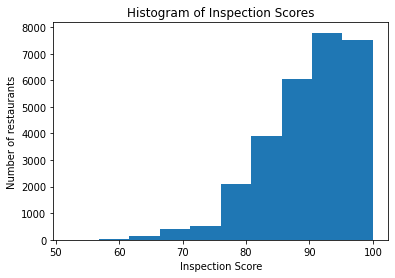

In [1184]:
plt.hist(df['calculated_score'], bins = 10)
plt.title('Histogram of Inspection Scores')
plt.xlabel('Inspection Score')
plt.ylabel('Number of restaurants');

In [1185]:
len(df.loc[df['calculated_score'] >= 80]) / len(df)

0.9436495939817907

We definitely see a left-skew with our data.  This comes as no surprise since the maximum score a restaurant can receive is 100, and 94% of restaurants receive an A or B, meaning that they do not require another visit until 6 months later.  Since we are approaching this as a multiclass classification problem, we may want to consider bootstrapping.

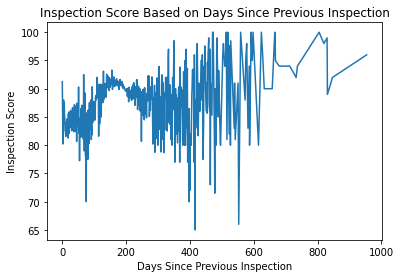

In [1186]:
plt.plot(df.groupby(['days_since_last_insp'])['calculated_score'].mean())
plt.title('Inspection Score Based on Days Since Previous Inspection')
plt.xlabel('Days Since Previous Inspection')
plt.ylabel('Inspection Score');

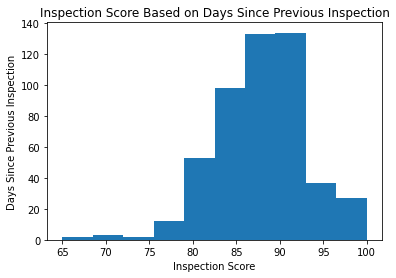

In [1187]:
plt.hist(df.groupby(['days_since_last_insp'])['calculated_score'].mean())
plt.title('Inspection Score Based on Days Since Previous Inspection')
plt.ylabel('Days Since Previous Inspection')
plt.xlabel('Inspection Score');

It's hard to decipher a pattern.  In general, it looks like there's an initial trend of score increasing based on the amount of days since the last inspection until a little before 200 dats, but there appears to be little pattern afterward.  This makes a lot of sense because places that score above 80 on an inspection do not typically get reinspected until about 180 days (6 months) later.

In [1188]:
df.loc[df['days_since_last_insp'] > 800]

,Restaurant Name,Inspection Date,Street Number,Street Name,Street Direction,Street Type,Street Unit,Street Address,Zip Code,Violation Description - 1,...,Violation Detail - 25,Violation Memo - 25,Inspection Month,Inspection Year,Lat Long Location,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,next_inspection_grade
23142,SHERATON DALLAS-BANQUET HALL,2019-01-28,443,OLIVE,N,ST,,443 N OLIVE ST,75201,*43 Clean vent syst:Intake/exhaust air ducts,...,,,Jan 2019,FY2019,"443 N OLIVE ST\n(32.785048, -96.795402)",99.0,92.0,830.0,1,A
26047,SANCHEZ'S PANADERIA Y TAQUERIA,2019-06-10,6131,LAKE JUNE,,PL,,6131 LAKE JUNE PL,75217,*28 Date marking commercially prepared RTE/ TC...,...,,,Jun 2019,FY2019,"6131 LAKE JUNE PL\n(32.734315, -96.715701)",92.0,80.0,847.0,1,B
27512,AFC SUSHI @TOM THUMB #2642,2019-08-28,5809,LOVERS,E,LN,,5809 E LOVERS LN,75206,,...,,,Aug 2019,FY2019,"5809 E LOVERS LN\n(32.851099, -96.766828)",100.0,82.0,805.0,1,B
27651,POPEYES,2019-09-05,3308,DAVIS,W,ST,,3308 W DAVIS ST,75211,*21 Person in charge. The person in charge sha...,...,,,Sep 2019,FY2019,"3308 W DAVIS ST\n(32.749482, -96.874487)",96.0,97.0,954.0,1,A
27721,TAQUERIA CHIMALHUACAH,2019-09-09,13350,AUDELIA,,RD,#100,13350 AUDELIA RD #100,75243,*45 Premises shall be maintained in good repair,...,,,Sep 2019,FY2019,"13350 AUDELIA RD #100\n(32.931073, -96.717957)",89.0,84.0,831.0,1,B
27862,THE CRAB STATION,2019-09-16,2813,COMMERCE,,ST,,2813 COMMERCE ST,75226,*38 Thawing. under running water criteria,...,,,Sep 2019,FY2019,"2813 COMMERCE ST\n(32.783315, -96.782596)",98.0,87.0,820.0,1,B


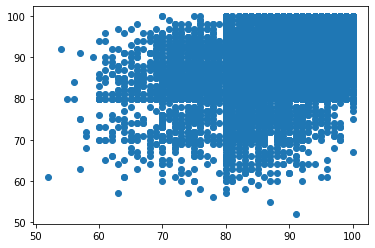

In [1189]:
plt.scatter(df['calculated_score'], df['next_inspection_score']);

In [1190]:
df.corr()

,Street Number,calculated_score,next_inspection_score,days_since_last_insp,inspection_count
Street Number,1.000000,0.000762,0.006015,-0.053875,0.019060
calculated_score,0.000762,1.000000,0.554437,0.078654,-0.079388
next_inspection_score,0.006015,0.554437,1.000000,0.105646,-0.088987
days_since_last_insp,-0.053875,0.078654,0.105646,1.000000,-0.376266
inspection_count,0.019060,-0.079388,-0.088987,-0.376266,1.000000


In [1191]:
df.groupby(df['next_inspection_grade']).corr()

Street Number  calculated_score  \
next_inspection_grade                                                          
A                     Street Number               1.000000         -0.002531   
                      calculated_score           -0.002531          1.000000   
                      next_inspection_score      -0.046383          0.404955   
                      days_since_last_insp       -0.051933          0.039460   
                      inspection_count            0.005313         -0.059159   
B                     Street Number               1.000000         -0.005232   
                      calculated_score           -0.005232          1.000000   
                      next_inspection_score       0.046140          0.226214   
                      days_since_last_insp       -0.060898          0.032256   
                      inspection_count            0.037270         -0.031986   
C                     Street Number               1.000000         -0.057415   
                      calculated_score           -0.057415          1.000000   
                      next_inspection_score       0.071288          0.152514   
                      days_since_last_insp       -0.072306          0.034341   
                      inspection_count            0.061853         -0.027236   
D                     Street Number               1.000000         -0.093032   
                      calculated_score           -0.093032          1.000000   
                      next_inspection_score       0.105921         -0.013831   
                      days_since_last_insp       -0.041185          0.092295   
                      inspection_count            0.047385         -0.098515   
F                     Street Number               1.000000         -0.010333   
                      calculated_score           -0.010333          1.000000   
                      next_inspection_score      -0.046050         -0.418728   
                      days_since_last_insp        0.191094          0.214949   
                      inspection_count           -0.047301         -0.576736   

                                             next_inspection_score  \
next_inspection_grade                                                
A                     Street Number                      -0.046383   
                      calculated_score                    0.404955   
                      next_inspection_score               1.000000   
                      days_since_last_insp                0.025061   
                      inspection_count                   -0.035050   
B                     Street Number                       0.046140   
                      calculated_score                    0.226214   
                      next_inspection_score               1.000000   
                      days_since_last_insp                0.037650   
                      inspection_count                   -0.026010   
C                     Street Number                       0.071288   
                      calculated_score                    0.152514   
                      next_inspection_score               1.000000   
                      days_since_last_insp                0.056899   
                      inspection_count                   -0.024709   
D                     Street Number                       0.105921   
                      calculated_score                   -0.013831   
                      next_inspection_score               1.000000   
                      days_since_last_insp                0.058561   
                      inspection_count                   -0.080841   
F                     Street Number                      -0.046050   
                      calculated_score                   -0.418728   
                      next_inspection_score               1.000000   
                      days_since_last_insp                0.106281   
                      inspection_count                   -0.0650

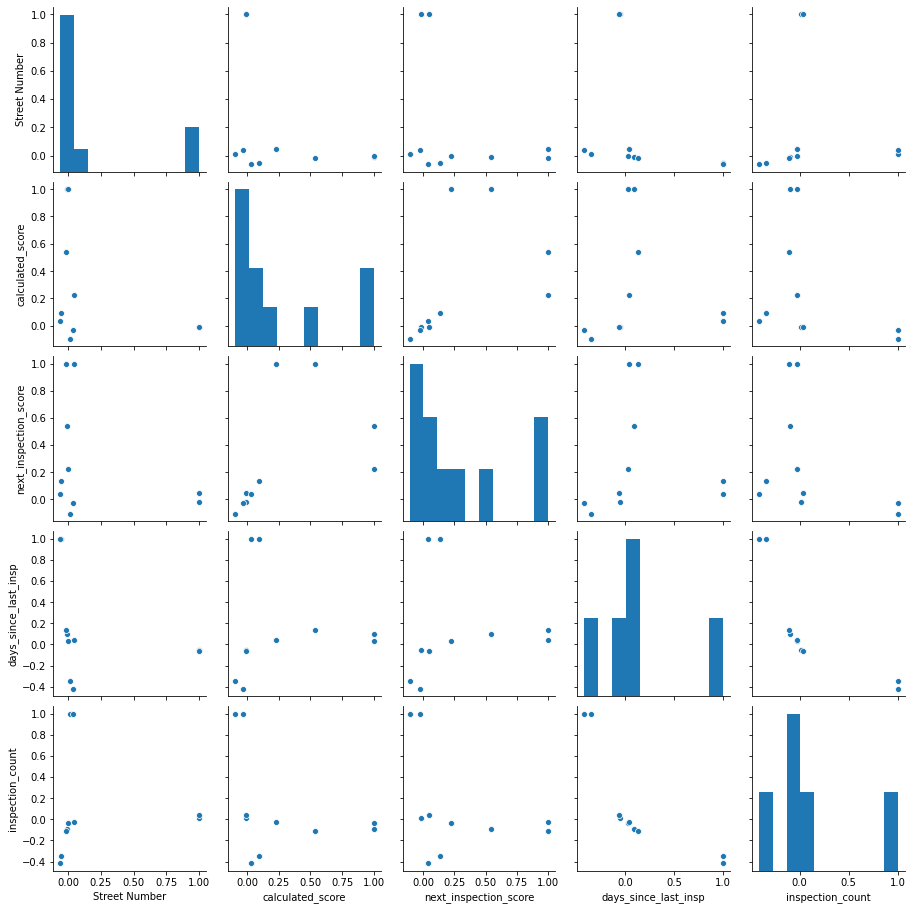

In [1192]:
sns.pairplot(df.groupby(df['next_inspection_grade'] == 'B').corr())

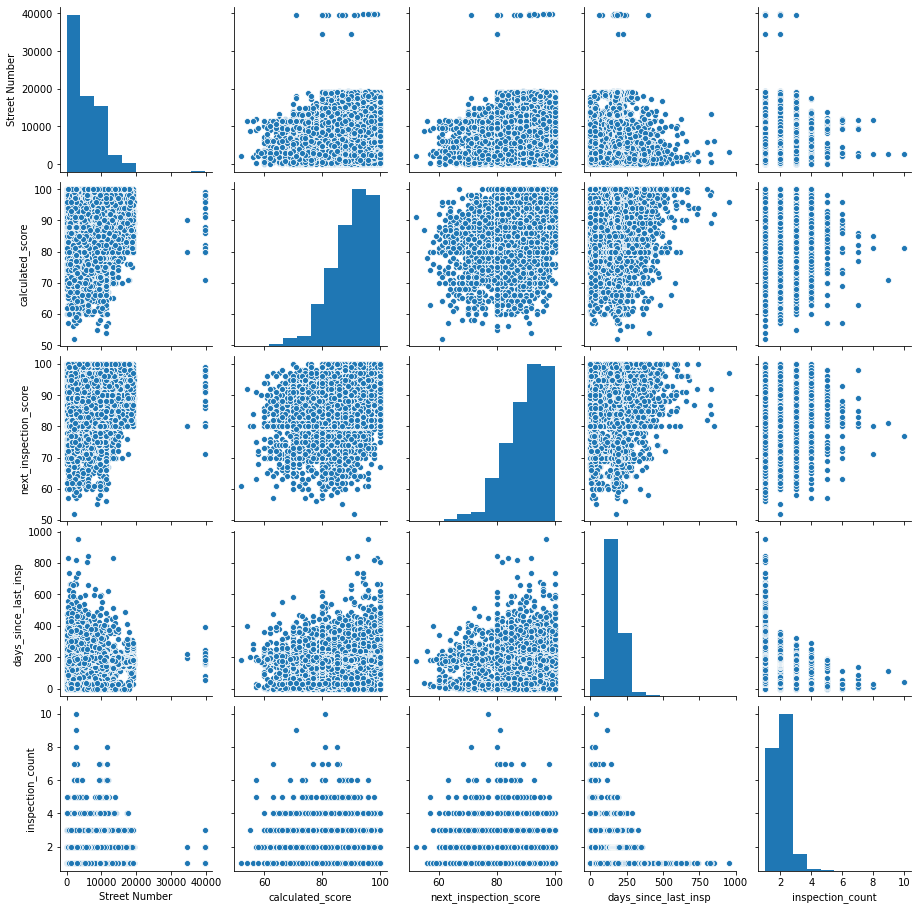

In [1193]:
sns.pairplot(df)

In [1194]:
df['calculated_score'].groupby(df['inspection_count']).mean()

inspection_count
1     90.151705
2     90.433203
3     87.414116
4     83.310811
5     82.288136
6     82.466667
7     78.833333
8     83.000000
9     71.000000
10    81.000000
Name: calculated_score, dtype: float64

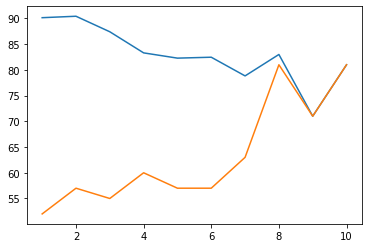

In [1195]:
plt.plot(df['calculated_score'].groupby(df['inspection_count']).mean())

plt.plot(df['calculated_score'].groupby(df['inspection_count']).min())

### Count Vectorizer

In [1136]:
string_cols = df.dtypes.loc[df.dtypes.values == 'object'].index 

str_to_drop = string_cols[1:6]

df.drop(columns = str_to_drop, inplace = True)

df.drop(columns = df.columns[2:3], inplace = True)

string_cols = df.dtypes.loc[df.dtypes.values == 'object'].index

In [1137]:
df['alltext'] = df[string_cols[:-1]].apply(
    lambda x: ' '.join(x.dropna().astype(str)), axis = 1)

# code is from Ed Chum on https://stackoverflow.com/questions/33098383/merge-multiple-column-values-into-one-column-in-python-pandas


In order to prepare for CountVectorizer, we need to merge all string columns into one column.  Let's drop the individual columns.

In [1138]:
df.drop(columns = string_cols, inplace=True)

In [989]:
list_of_strings = df['alltext']

In [990]:
cvec = CountVectorizer(lowercase = True, # turn everything to lower case
                       ngram_range = (1, 3),
                      stop_words= 'english',
                       max_features= 2100) # 

# data run through cvec must be transformed
X_text = cvec.fit_transform(list_of_strings)

Originally, I ran a grid search to find the best parameters for CountVectorizer.  If I didn't limit my max features, I would end up with almost 800,000 features, and modeling with that amount was not feasible on my machine, given the time constraint and budget of the project.

In [991]:
X_text_df = pd.DataFrame(X_text.toarray(),
                      columns = cvec.get_feature_names())


In [992]:
X_text_df.head()

,02,02 cold,02 cold hold,03,03 food,03 food products,07,07 food,07 food safe,09,...,õ228 111,õ228 111 title,õ228 206,õ228 206 title,õ228 71,õ228 71 title,õ228 73,õ228 73 title,õ228 78,õ228 78 title
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0


In [1005]:
df.drop(columns = ['Inspection Date', 'alltext'], inplace=True)

In [1006]:
X_text_df[df.columns] = df

In [1007]:
X_text_df

,02,02 cold,02 cold hold,03,03 food,03 food products,07,07 food,07 food safe,09,...,õ228 71 title,õ228 73,õ228 73 title,õ228 78,õ228 78 title,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,next_inspection_grade
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,96.0,100.0,0.0,2,A
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,97.0,94.0,0.0,2,A
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,91.0,90.0,0.0,2,A
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,80.0,81.0,7.0,2,B
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,81.0,73.0,11.0,2,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28442,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,80.0,91.0,166.0,1,A
28443,1,1,1,1,1,1,0,0,0,1,...,1,1,1,0,0,70.0,95.0,197.0,1,A
28444,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,69.0,89.0,190.0,1,B
28445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,96.0,95.0,369.0,1,A


In [1008]:
X = X_text_df.drop(columns = ['next_inspection_score', 'next_inspection_grade']) #predictive variable
y = X_text_df['next_inspection_grade']

In [1009]:
X.shape

(28447, 2103)

In [1010]:
y.shape

(28447,)

# Modeling

In [1011]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 63, stratify = y)

# Baseline

In [1012]:
y.value_counts()/len(df)

A    0.603825
B    0.349316
C    0.038668
D    0.007839
F    0.000352
Name: next_inspection_grade, dtype: float64

Baseline model would perform at 60.3% accuracy, which would be if my model predicted A every time.

In [1013]:
pipe = Pipeline([ #instantiate transformers and model 
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(random_state = 63))
])

# set hyperparameters

pipe_params = {'tfidf__use_idf'  : [True, False], #toggle between use of TFIDF
              'lr__solver': ['lbfgs'],
              'lr__penalty': ['l2']}

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 3, # cross validation of 3
                 scoring = 'accuracy',
                 verbose = 2)

In [1014]:
logreg1 = gs.fit(X_train,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True, total=  16.0s
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.1s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True, total=  15.0s
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True ...........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=True, total=  14.6s
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False, total=  14.5s
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False, total=  14.5s
[CV] lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False ..........


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__penalty=l2, lr__solver=lbfgs, tfidf__use_idf=False, total=  13.8s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.5min finished
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [1015]:
print(f'Training accuracy score for our Logistic Regression model is: {round(logreg1.score(X_train, y_train),4)}.')
print(f'Testing accuracy score for our Logistic Regression model is: {round(logreg1.score(X_test, y_test),4)}.')

Training accuracy score for our Logistic Regression model is: 0.6965.
Testing accuracy score for our Logistic Regression model is: 0.69.


In [1016]:
logreg1.best_params_

{'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'tfidf__use_idf': True}

In [1017]:
cross_val_score(logreg1.best_estimator_, X, y).mean()

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

0.6852746010940238

# MNB

In [1018]:
pipe = Pipeline([ # instantiate
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())
])

# set hyperparameters

pipe_params = {
    'tfidf__use_idf'  : [False],
    'mnb__fit_prior' : [False],          
    'mnb__alpha': [2] #tested out other alpha values and got it narrowed to this
              }

gsnb = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2 # let's get progress updates in real time this time
                   )

In [1019]:
X_train.shape

(21335, 2103)

In [1020]:
mnb_fit = gsnb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] mnb__alpha=2, mnb__fit_prior=False, tfidf__use_idf=False ........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  mnb__alpha=2, mnb__fit_prior=False, tfidf__use_idf=False, total=   5.8s
[CV] mnb__alpha=2, mnb__fit_prior=False, tfidf__use_idf=False ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV]  mnb__alpha=2, mnb__fit_prior=False, tfidf__use_idf=False, total=   4.8s
[CV] mnb__alpha=2, mnb__fit_prior=False, tfidf__use_idf=False ........
[CV]  mnb__alpha=2, mnb__fit_prior=False, tfidf__use_idf=False, total=   5.7s
[CV] mnb__alpha=2, mnb__fit_prior=False, tfidf__use_idf=False ........
[CV]  mnb__alpha=2, mnb__fit_prior=False, tfidf__use_idf=False, total=   5.1s
[CV] mnb__alpha=2, mnb__fit_prior=False, tfidf__use_idf=False ........
[CV]  mnb__alpha=2, mnb__fit_prior=False, tfidf__use_idf=False, total=   4.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.5s finished


In [1021]:
mnb_fit.best_params_

{'mnb__alpha': 2, 'mnb__fit_prior': False, 'tfidf__use_idf': False}

In [1022]:
mnb_fit.score(X_train, y_train)

0.6780876494023904

In [1023]:
mnb_fit.score(X_test, y_test)

0.672665916760405

In [1024]:
cross_val_score(mnb_fit.best_estimator_, X, y).mean()

0.672936252583764

# PCA

In [1025]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [1026]:
# code from Austin Ricardson at https://stats.stackexchange.com/questions/144439/applying-pca-to-test-data-for-classification-purposes
# fits PCA, transforms data and fits the decision tree classifier
# on the transformed data
pipe = Pipeline([('pca', PCA()),
                 ('tree', DecisionTreeClassifier())])

pipe_params = {

              }

gspca = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 3,
                 scoring = 'accuracy',
                 verbose = 2 # let's get progress updates in real time this time
                   )



In [1027]:
pca_model = gspca.fit(X_train_sc, y_train)



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total=  59.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.3min finished


In [1028]:
pca_model.score(X_train_sc, y_train)

0.9990625732364659

In [1029]:
pca_model.score(X_test_sc, y_test)

0.5795838020247469

# Neural Network

In [1030]:
y.replace({
    'A' : 4,
    'B' : 3,
    'C' : 2,
    'D' : 1,
    'F' : 0
}, inplace=True)

In [1031]:
y = to_categorical(y)

In [1032]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=63)

In [1033]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [1034]:
y.shape

(28447, 5)

In [1035]:
model = Sequential()
model.add(Dense(1024, 
                input_shape=(2103,),
                activation='relu'))
model.add(Dense(512,
                activation='relu'))
model.add(Dense(5, activation='softmax'))

In [1036]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [1037]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=700)

Epoch 1/10
31/31 [==============================] - 5s 155ms/step - loss: 3.6459 - accuracy: 0.5906 - val_loss: 0.8928 - val_accuracy: 0.6492
Epoch 2/10
31/31 [==============================] - 6s 182ms/step - loss: 0.7444 - accuracy: 0.6777 - val_loss: 0.7065 - val_accuracy: 0.6904
Epoch 3/10
31/31 [==============================] - 5s 172ms/step - loss: 0.6907 - accuracy: 0.7011 - val_loss: 0.7206 - val_accuracy: 0.6856
Epoch 4/10
31/31 [==============================] - 5s 170ms/step - loss: 0.6878 - accuracy: 0.6974 - val_loss: 0.7048 - val_accuracy: 0.6867
Epoch 5/10
31/31 [==============================] - 5s 155ms/step - loss: 0.6726 - accuracy: 0.7041 - val_loss: 0.7049 - val_accuracy: 0.6873
Epoch 6/10
31/31 [==============================] - 5s 155ms/step - loss: 0.6688 - accuracy: 0.7083 - val_loss: 0.7106 - val_accuracy: 0.6776
Epoch 7/10
31/31 [==============================] - 6s 185ms/step - loss: 0.6570 - accuracy: 0.7144 - val_loss: 0.7057 - val_accuracy: 0.6877
Epoch 

In [1038]:
model.predict_classes(X_test)

array([4, 4, 4, ..., 4, 4, 3])

# Model Evaluation

In [1039]:
preds = logreg1.predict(X_test)

In [1040]:
logreg1.best_estimator_.steps[0]

('tfidf',
 TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))

In [1041]:
coef_df = {
    "column" : X_test.columns ,
    "coef"   : logreg1.best_estimator_.steps[1][1].coef_

}

In [1042]:
coefs = logreg1.best_estimator_.steps[1][1].coef_

In [1043]:
coef_df = pd.DataFrame(coefs).T

In [1044]:
coef_df.index = X_test.columns

In [1045]:
coef_df.rename(columns={0 : 'A', 
                        1 : 'B',
                        2 : 'C',
                        3 : 'D',
                        4 : 'F'}, inplace= True)

In [1066]:
coef_df['A'].sort_values().tail(30)

71                       0.435501
mar                      0.436701
manufacturer             0.440467
temperature measuring    0.449536
2018                     0.453053
service manager          0.454636
covered                  0.455203
food service manager     0.457592
written                  0.463425
inspection report        0.471536
cooler                   0.497596
debris clean             0.517477
dust                     0.526379
sign                     0.530815
residue debris clean     0.536293
splash                   0.545397
broken                   0.550124
thermometer              0.571716
wash                     0.698444
2018 fy2018              0.703112
dirty                    0.739958
report                   0.771668
fy2018                   0.774501
exposed splash           0.797714
manager                  0.816174
provide                  0.909066
need                     0.996654
days                     1.234078
days_since_last_insp     1.546280
calculated_sco

All violations begin with 228, so this comes as no surprise.

In [1060]:
coef_df['B'].sort_values()

need             -0.843870
2018 fy2018      -0.757339
wash             -0.736959
exposed splash   -0.710789
report           -0.680064
                    ...   
kitchen           0.618624
fy2019            0.666853
criteria          0.669006
replace           0.750669
walls             0.769392
Name: B, Length: 2103, dtype: float64

In [1061]:
coef_df['C'].sort_values()

calculated_score   -1.656572
provide            -0.722510
days               -0.542778
food containers    -0.528401
avoid              -0.457575
                      ...   
228                 0.850446
drain               0.859599
self                0.882943
shall               1.176586
food                1.770606
Name: C, Length: 2103, dtype: float64

In [1062]:
coef_df['D'].sort_values()

calculated_score       -1.303184
days_since_last_insp   -0.743219
clean                  -0.413990
provide                -0.319318
hair                   -0.280309
                          ...   
228                     0.575524
shall                   0.579666
raw                     0.716474
cooling                 0.723023
food                    1.562919
Name: D, Length: 2103, dtype: float64

In [1059]:
coef_df['F'].sort_values()

days_since_last_insp   -1.241805
calculated_score       -0.297675
hair                   -0.085362
light                  -0.066791
restraints             -0.055349
                          ...   
water                   0.139536
time                    0.162398
waste                   0.163792
sources                 0.198695
food                    0.237149
Name: F, Length: 2103, dtype: float64

In [1047]:
X_eval_df = X_text_df.iloc[X_test.index]

In [1048]:
X_eval_df['preds'] = preds

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1049]:
X_eval_df.loc[(X_eval_df['next_inspection_score'] < 80) & ((X_eval_df['preds'] == 'A'))]


,02,02 cold,02 cold hold,03,03 food,03 food products,07,07 food,07 food safe,09,...,õ228 73,õ228 73 title,õ228 78,õ228 78 title,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,next_inspection_grade,preds
22229,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,96.0,74.0,175.0,1,2,A
8872,1,1,1,1,1,1,0,0,0,0,...,1,1,0,0,88.0,77.0,160.0,1,2,A
27506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,91.0,77.0,172.0,2,2,A
6120,1,1,1,1,1,1,0,0,0,0,...,1,1,0,0,86.0,73.0,160.0,2,2,A
18418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,92.0,78.0,33.0,3,2,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24184,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,92.0,76.0,168.0,1,2,A
19517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,91.0,75.0,201.0,2,2,A
4080,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,88.0,70.0,168.0,2,2,A
15230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,100.0,78.0,171.0,2,2,A


In [1050]:
X_eval_df.loc[(X_eval_df['calculated_score'] >= 90) & ((X_eval_df['preds'] != 'A'))]


,02,02 cold,02 cold hold,03,03 food,03 food products,07,07 food,07 food safe,09,...,õ228 73,õ228 73 title,õ228 78,õ228 78 title,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,next_inspection_grade,preds
12110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,90.0,92.0,160.0,1,4,B
19830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,92.0,84.0,12.0,1,3,B
531,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,91.0,96.0,176.0,2,4,B
6483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,90.0,83.0,203.0,1,3,B
1421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,93.0,99.0,16.0,1,4,B
25745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,90.0,100.0,29.0,3,4,B
14499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,94.0,83.0,36.0,3,3,B
4243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,90.0,82.0,168.0,2,3,B
8772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,92.0,90.0,14.0,2,4,B
12051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,91.0,83.0,165.0,1,3,B


In [1051]:
X_eval_df.loc[X_eval_df['preds'] == 'C']


,02,02 cold,02 cold hold,03,03 food,03 food products,07,07 food,07 food safe,09,...,õ228 73,õ228 73 title,õ228 78,õ228 78 title,calculated_score,next_inspection_score,days_since_last_insp,inspection_count,next_inspection_grade,preds
13964,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,69.0,92.0,16.0,4,4,C
16444,1,1,1,1,1,1,0,0,0,1,...,1,1,0,0,70.0,83.0,11.0,2,3,C
10061,1,1,1,0,0,0,2,0,0,1,...,0,0,0,0,61.0,96.0,2.0,2,4,C
23427,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,65.0,89.0,30.0,2,3,C
22452,1,1,1,1,1,1,0,0,0,1,...,1,1,0,0,58.0,68.0,22.0,2,1,C
10428,2,2,2,1,1,1,0,0,0,1,...,1,1,0,0,64.0,96.0,5.0,2,4,C


In [1052]:
# Filter on follow-up only
# Match them with their routine
# put them side by side

# add success metric and models to problem statement
# finish EDA

In [1053]:
# set up target column (essentially a lag of -1, added a new column)
# X is everything from the previous visit
# y is the future score